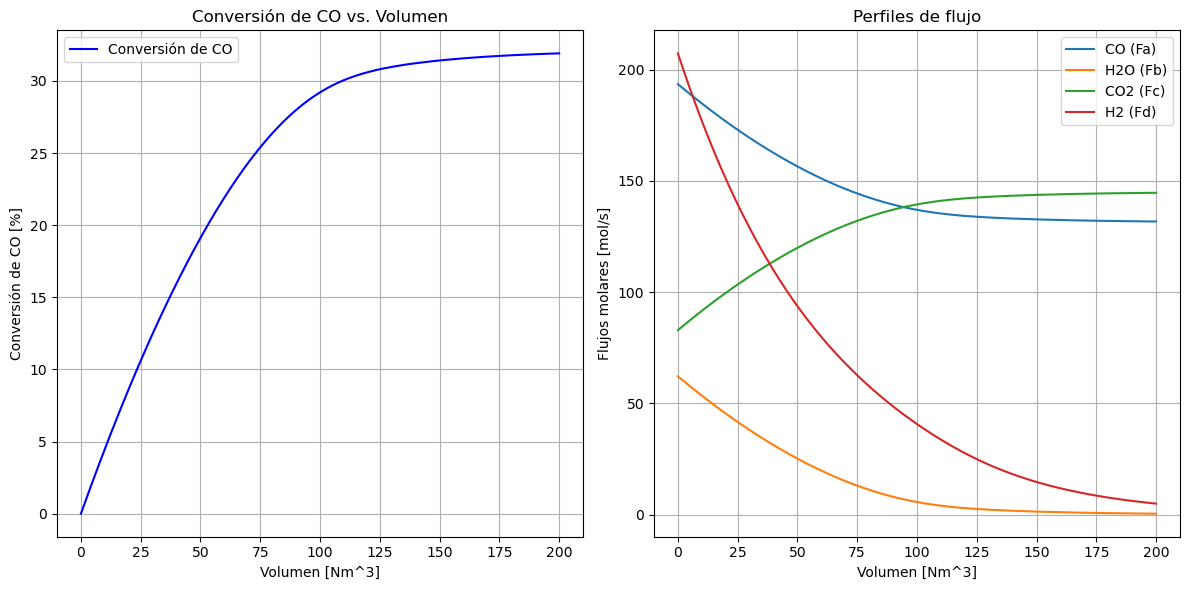

In [6]:
import numpy as np
import math
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

# ---------------------------------------------------------------------------
# 1) Definición de datos del problema y parámetros
# ---------------------------------------------------------------------------
R = 8.314        # [J/(mol*K)]
T = 673.15       # [K]
Pt = 2700.0      # [kPa]  (presión total constante)
Pe = 5.5e-6      # [mol m/(m^2 s Pa)] (permeabilidad de H2)
A0 = 2.51        # [m^2] (área de contacto de la membrana)
ye = 1.1e-3      # [m] (espesor de la membrana)

# Flujos molares iniciales [mol/s]
Fa0 = 580.482 /3   # CO
Fb0 = 62.1945    # H2O
Fc0 = 82.926     # CO2
Fd0 = 207.315    # H2
Fe0 = 1140.2325  # N2 (inerte)
y0 = [Fa0, Fb0, Fc0, Fd0, Fe0]

# Rango de integración en términos del volumen [Nm^3]
V_ini = 0.0
V_fin = 200

# ---------------------------------------------------------------------------
# 2) Cálculo de la constante de equilibrio K
# ---------------------------------------------------------------------------
K = math.exp(
    (5693.5 / T)
    + 1.077 * math.log(T)
    + 5.44e-4 * T
    - 1.125e-7 * (T**2)
    - (49170.0 / (T**2))
    - 13.148
)

# ---------------------------------------------------------------------------
# 3) Definimos la función de velocidad de reacción r(Pa, Pb, Pc, Pd)
# ---------------------------------------------------------------------------
def reaction_rate(Pa, Pb, Pc, Pd):
    """Calcula la velocidad de reacción (r)."""
    pre_exp = 0.008 * math.exp(-60.3 / (R * T))  # factor pre-exponencial
    term_p = (Pa**0.75) * (Pb**0.31) * (Pc**-0.072) * (Pd**-0.09)
    term_equil = 1.0 - (Pc * Pd) / (Pa * Pb * K)
    return pre_exp * term_p * term_equil

# ---------------------------------------------------------------------------
# 4) Sistema de EDOs: dFa/dV, dFb/dV, dFc/dV, dFd/dV, dFe/dV
# ---------------------------------------------------------------------------
def membrane_reactor_odes(V, F):
    """
    Define las ecuaciones diferenciales del reactor de membrana.
    """
    Fa, Fb, Fc, Fd, Fe = F
    
    # Flujo total
    Ft = Fa + Fb + Fc + Fd + Fe
    
    # Fracciones molares
    ya = Fa / Ft  # CO
    yb = Fb / Ft  # H2O
    yc = Fc / Ft  # CO2
    yd = Fd / Ft  # H2
    
    # Presiones parciales en kPa
    Pa = max(ya * Pt, 1e-6)  # Evitar valores negativos
    Pb = max(yb * Pt, 1e-6)
    Pc = max(yc * Pt, 1e-6)
    Pd = max(yd * Pt, 1e-6)
    
    # Velocidad de reacción
    r = reaction_rate(Pa, Pb, Pc, Pd)
    
    # Flujo de permeación de H2
    J_H2 = (Pe * A0 / ye) * Pd  # [mol/(s·Nm^3)]
    
    # Ecuaciones diferenciales
    dFa_dV = -r          # CO se consume
    dFb_dV = -r          # H2O se consume
    dFc_dV = +r         # CO2 se forma
    dFd_dV = +r - J_H2)   # H2 se forma y se permea
    dFe_dV = 0.0         # N2 es inerte
    
    return [dFa_dV, dFb_dV, dFc_dV, dFd_dV, dFe_dV]

# ---------------------------------------------------------------------------
# 5) Resolver las ecuaciones diferenciales con solve_ivp
# ---------------------------------------------------------------------------
sol = solve_ivp(
    fun=membrane_reactor_odes,
    t_span=(V_ini, V_fin),
    y0=y0,
    dense_output=True
)

# Chequeo de éxito
if not sol.success:
    raise RuntimeError(f"La integración falló: {sol.message}")

# ---------------------------------------------------------------------------
# 6) Post-proceso: graficar la conversión y los flujos molares
# ---------------------------------------------------------------------------
V_grid = np.linspace(V_ini, V_fin, 200)
F_sol = sol.sol(V_grid)  # matriz con shape=(5, len(V_grid))

Fa_sol = F_sol[0]
Fb_sol = F_sol[1]
Fc_sol = F_sol[2]
Fd_sol = F_sol[3]
Fe_sol = F_sol[4]

# Cálculo de la conversión de CO en cada punto
x_sol = (Fa0 - Fa_sol) / Fa0 * 100

# Gráficas
plt.figure(figsize=(12, 6))

# -- Conversión vs. Volumen
plt.subplot(1, 2, 1)
plt.plot(V_grid, x_sol, 'b-', label='Conversión de CO')
plt.xlabel('Volumen [Nm^3]')
plt.ylabel('Conversión de CO [%]')
plt.title('Conversión de CO vs. Volumen')
plt.grid(True)
plt.legend()

# -- Flujos molares vs. Volumen
plt.subplot(1, 2, 2)
plt.plot(V_grid, Fa_sol, label='CO (Fa)')
plt.plot(V_grid, Fb_sol, label='H2O (Fb)')
plt.plot(V_grid, Fc_sol, label='CO2 (Fc)')
plt.plot(V_grid, Fd_sol, label='H2 (Fd)')
#plt.plot(V_grid, Fe_sol, label='N2 (Fe)')
plt.xlabel('Volumen [Nm^3]')
plt.ylabel('Flujos molares [mol/s]')
plt.title('Perfiles de flujo')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()
